<a href="https://colab.research.google.com/github/Heity94/TWSM_Lab/blob/main/Project/Team1_ProjectReport_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Report - Team 1

###**Task:** How to automatically update the ontology? 

Team members: 
- Johana Estrada (777211902958)
- Philipp Heitmann (77211890824)
- Minh Anh Hoang (77211887950)
- Theresa Ewert (77210570462)

<br>
Text Web Social Media Analytics Lab SS2022<br>
Prof. Dr. Markus Löcher <br>
Program: Business Intelligence & Process Management<br>
HWR Berlin

##### Install missing packages and imports

In [4]:
# Install missing dependencies
!pip install duckdb -q
!pip install -U sentence-transformers -q

     |████████████████████████████████| 15.7 MB 7.8 MB/s 
     |████████████████████████████████| 85 kB 4.0 MB/s 
     |████████████████████████████████| 4.4 MB 15.9 MB/s 
     |████████████████████████████████| 1.2 MB 68.3 MB/s 
     |████████████████████████████████| 101 kB 15.1 MB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
     |████████████████████████████████| 6.6 MB 56.0 MB/s 


In [5]:
# Import all packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import duckdb
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator, TripletEvaluator, LabelAccuracyEvaluator

In order to be able to run our notebook you need to mount the notebook to the drive directory of the project `2022_Analytics Lab Student Projects`.

Please note that apart from the common `data` directory which includes the data from the ontology, sentences etc. we also created a separate folder `Data_Team1` which contain our modeling/ intermediate results

In [1]:
# Mount drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#set data paths
data_path = "/content/drive/MyDrive/2022_Analytics Lab Student Projects/Data/All Topics" #to access provided data from ontoogy etc.
data_path_group = data_path[:-10]+"Topic 1/Data_Team1/" #to access files created by Team1

## Introduction


## Ideal architecture

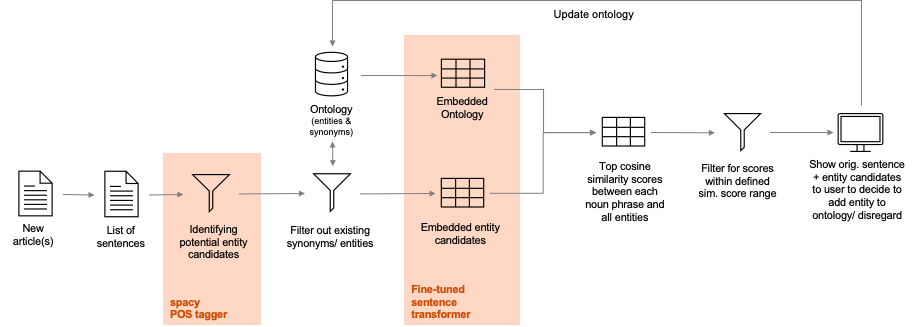

### spaCy & noun phrase extraction

### Entities & Synonyms

### Similarity comparison and filtering results for user

## Model selection and finetuning

So now that you have seen our main idea on how to solve this tasks and the complications we faced there, we are now at the point on where we want to make sure that our model embeddings are up to the task of identifying:

1. Synonyms of already existing entities and 
2. New entities which are not present in the ontology yet

Ideally the model embeddings should put the entites & corresponding synonyms close to each other, while maintaining a certain distance to other entities.

Additionally for NER, the child entity should also be located close to the correct "parent" entity

In order to let the model learn these relationships we created different training datasets, which we then used to further fine tune our model before we evaluate it on the "original" task. (See picture below)

-------------

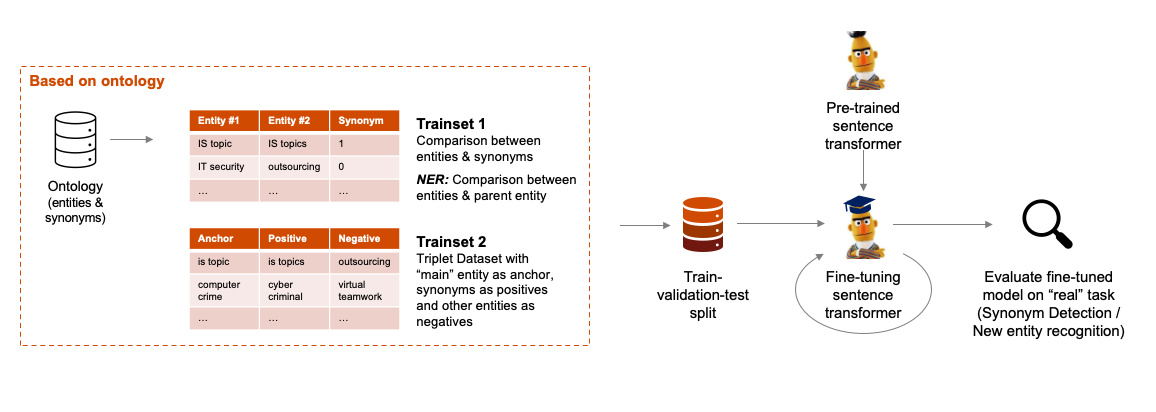

> ❗ Please note that the order shown in the above picture is not identical to our procedure in the project. As the train-validattion-test split of the ontology was the harder task, we created the train-validation-test first and then created the dataset. In order to replay our code completely you would need to execute the following notebooks in the correct order:
1. BLOCKER
2. BLOCKER
3. BLOCKER

### Create training datasets for finetuning the model on the ontology

In order to let the model learn these relationships/ similarities, we created two different training datasets for finetuning, which are based on the current ontology:

1. **Trainset 1 ("Synonym Dataset")**
  - Classification of true/ false entities/synonym pairs 
  - For NER we additonally created an additional version of this dataset to classify entity and parent entity pairs

2. **Trainset 2 ("Triplets Dataset")**
  - This trainingset is inspired by the Sentence-BERT paper
  - The triplets dataset consists of an 
    - **Anchor phrase** --> an entity from the ontology, 
    - **Positive example** --> synonym of the anchor and
    - **Negative example** --> another entity from the same "area" of the ontology
  - The training goal is that the model puts the positive example closer to the anchor than the negative example. 

<br>

>❗ Please note that we created two versions of each dataset. One for synonym detection and one for NER. In order to limit the size of the notebook we will only include the creation of one dataset each (NER). The code for the remaining ones can be found in the corresponding notebook(s) mentioned below.


For further details please see notebook: `NOTEBOOK NAME HERE`

#### Synonyms Dataset

- For the Synonym Datatset we create a dataset which include all true synonyms from the ontology as well as negative examples. 
- For the negative examples we randomly draw 100 other entity id from the training set which do not belong to this entity, but are in the same `category` (to ensure some more or less meaningful relation)

##### Load data

In [6]:
# Load train-val-test splits of entities/noun phrases
NER_entities_train_df = pd.read_csv(data_path_group+"NER/NER_entities_train.csv", index_col=0)
NER_entities_val_df = pd.read_csv(data_path_group+"NER/NER_entities_val.csv", index_col=0)
NER_entities_test_df = pd.read_csv(data_path_group+"NER/NER_entities_test.csv", index_col=0)

In [8]:
NER_entities_train_df.sample(1)

,article_id,sentence_id,ent_id,noun_phrases,true_ent_id
1986028,4089,4089_1839_1879,top IS journal,the 100 most impactful recent papers,0


In [ ]:
# Load train-val-test splits of ontology
NER_ontology_train_df = pd.read_csv(data_path_group+"NER/NER_ontology_train.csv", index_col=0)
NER_ontology_val_df = pd.read_csv(data_path_group+"NER/NER_ontology_val.csv", index_col=0)
NER_ontology_test_df = pd.read_csv(data_path_group+"NER/NER_ontology_test.csv", index_col=0)

In [9]:
NER_ontology_train_df.sample(1)

,entity_id,category,label,synonym
196504,individual participant,study object,PARTICIPANTS,security and security security individuals


##### Create functions to create dataset

In [11]:
def rand_sample_false_syn(x, ontology_df):
  ''' Create false synonym samples for synonyms dataset'''

  try:
      return np.random.choice(ontology_df[
                              (ontology_df.category==x.category)&
                              (ontology_df.entity_id!=x.entity_id)
                              ]
                          .entity_id.unique(),100, replace=True)    
  
  except:
      return np.random.choice(ontology_df[
                      #(ontology_df.category==x.category)&
                      (ontology_df.entity_id!=x.entity_id)
                      ]
                  .entity_id.unique(),100, replace=True)    

In [13]:
def create_synonyms_dataset(ontology_df, return_false_syn=True):
    '''Create synonyms dataset (positive and negative examples) '''

    #Filter out identical rows (main entity and synonym is the same word/phrase)
    ontology_df = ontology_df.loc[ontology_df.entity_id!=ontology_df.synonym]

    # Add new column to label whether entity_id and synonym are indeed synonmys
    ontology_df["is_synonym"] = 1

    ontology_false_synonyms_df = ontology_df[["entity_id", "category", "label"]].drop_duplicates("entity_id")

    ontology_false_synonyms_df["synonym"] = ontology_false_synonyms_df.apply(
                                        lambda x: rand_sample_false_syn(x,ontology_df), axis=1)

    ontology_false_synonyms_df["is_synonym"]=0
    ontology_false_synonyms_df = ontology_false_synonyms_df.explode("synonym")

    # Drop duplicates (because we draw with replacement)
    ontology_false_synonyms_df = ontology_false_synonyms_df.drop_duplicates()

    ontology_df = pd.concat([ontology_df, ontology_false_synonyms_df], axis=0).reset_index(drop=True).sample(frac=1)

    if return_false_syn==False:
        return ontology_df

    return ontology_df, ontology_false_synonyms_df

In [14]:
## Create datasets
#NER_ontology_train_df_syn, ontology_false_syn_train_df = create_synonyms_dataset(NER_ontology_train_df)
#NER_ontology_val_df_syn, ontology_false_syn_val_df = create_synonyms_dataset(NER_ontology_val_df)
#NER_ontology_test_df_syn, ontology_false_syn_test_df = create_synonyms_dataset(NER_ontology_test_df)

In [18]:
# Load dataset to show result
NER_ontology_train_df_syn = pd.read_csv(data_path_group+"NER/Synonym_Dataset/NER_ontology_train_df_syn.csv", index_col=0)
NER_ontology_train_df_syn.head(1)

,entity_id,category,label,synonym,is_synonym
533794,smart contract,domain specific entity,TECHNOLOGY,intelligent process automation,0


#### Triplets Dataset

- For the Triplets Datatset we set the "main" entity as the anchor, synonyms as positive and other entities from the same `categroy` as negative examples
- We reuse some of the code/ output from the synonym dataset

##### Create functions to create dataset

In [19]:
def create_triplets_dataset(ontology_df, ontology_false_syn_df):
    ''' Create triplets dataset'''

    ontology_triplets_df = ontology_df.merge(ontology_false_syn_df, how="inner", on="entity_id")

    ontology_triplets_df = ontology_triplets_df.loc[ontology_triplets_df.is_synonym_x==1]

    ontology_triplets_df = ontology_triplets_df.sample(frac=1)\
                                .drop_duplicates(["entity_id", "synonym_x"])\
                                .loc[:,["entity_id", "synonym_x", "synonym_y"]]\
                                .reset_index(drop=True)

    # Rename columns
    ontology_triplets_df.columns = ["entity_id", "positive_example", "negative_example"]

    ontology_triplets_df = ontology_triplets_df.drop_duplicates(["entity_id", "negative_example"])

    return ontology_triplets_df


In [22]:
## Create datasets
#NER_ontology_train_triplets = create_triplets_dataset(NER_ontology_train_df_syn, ontology_false_syn_train_df)
#NER_ontology_val_triplets = create_triplets_dataset(NER_ontology_val_df_syn, ontology_false_syn_val_df)
#NER_ontology_test_triplets = create_triplets_dataset(NER_ontology_test_df_syn, ontology_false_syn_test_df)

In [23]:
# Load dataset to show result
NER_ontology_train_triplets = pd.read_csv(data_path_group+"NER/Triplets_Dataset/NER_ontology_val_triplets.csv", index_col=0)
NER_ontology_train_triplets.head(1)

,entity_id,positive_example,negative_example
0,IT strategic planning,package strategic planning,hedge fund


### Train-validation-test split of the ontology

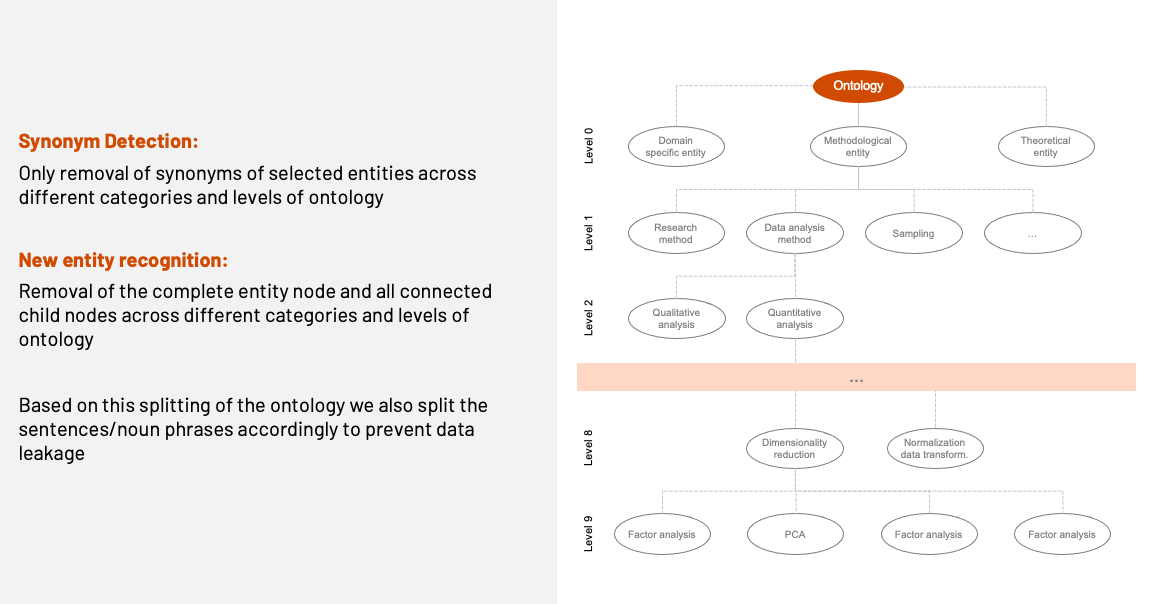

For further details please see notebook: `NOTEBOOK NAME HERE`

## Finetuning the models

### Finetuning for synonym detection task

### Finetuning for new entity recognition task

### Compare model performance on training sets

#### Synonym detection

#### New Entity Recognition 

## Evaluate model performance on actual task


### Synonym Detection

### New Entity Recognition

## Recommendations & Outlook